In [1]:
import os
from PIL import Image
import time

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.layers import Input, Dropout, Add, Dense, Reshape, Activation
from keras.layers import BatchNormalization, Flatten, Conv2D, MaxPooling1D
from tensorflow.keras.optimizers import Adam




2025-05-06 01:17:13.679347: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 01:17:13.711282: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## GPU Config

Check that it's available, and configure it

In [3]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:", gpus)
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-05-06 01:17:14.702872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-06 01:17:14.711802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-06 01:17:14.714660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Data Exploration

In [4]:
import os
count = 50
counter = 0
DATASET_ROOT_DIR = './datasets'
for dirname, _, filenames in os.walk(DATASET_ROOT_DIR):
    for filename in filenames:        
        counter += 1
        if counter % 30 == 0:
            counter = 0
            img = plt.imread(dirname + '/' + filename)
            print(dirname + '/' + filename, img.shape)

./datasets/remote-keyless-entry/d2d40fcad82f4b48808ca0003035f9bf.png (302, 302, 3)
./datasets/remote-keyless-entry/055c6c36bf883f7c5c859f3d5a5e3728.png (480, 573, 4)
./datasets/remote-keyless-entry/920e00156b7ad9dfb493a45f419d637a.png (473, 743, 4)
./datasets/remote-keyless-entry/4bdb9f096b373092d2681b2b3ae0ad64.png (490, 619, 4)
./datasets/pocsag/c946a9e946188e5f4ddfbe6a6f5fef83.jpg (427, 1459, 3)
./datasets/digital-speech-decoder/f53ae9cb39598b505bf66943978b698c.png (483, 1360, 4)
./datasets/digital-speech-decoder/70e23c926ebe965524396e2c4bb680d4.png (482, 899, 4)
./datasets/vor/fd6e4c3603fccd0ae9e611350e7e284a.png (597, 1220, 4)
./datasets/vor/d70be15c64101c26b3d1b2f0bf9d8321.png (597, 1220, 4)
./datasets/on-off-keying/1e297dc0fdf417bcb85c3f100084d7fc.jpg (427, 574, 3)
./datasets/on-off-keying/f03742f107ef43e9a5bee71e488c806e.jpg (277, 1476, 3)
./datasets/sstv/0f7173646ff89f07f404a78692c2f09d.png (598, 448, 4)
./datasets/sstv/1c6bd76a91147eea157179640ae499ea.png (598, 448, 4)
./data

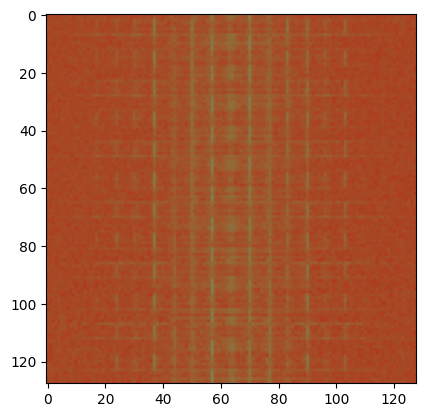

In [6]:
file = './datasets/automatic-picture-transmission/f7a3be24e8b2f2755e07bd98b474f09e.png'
IMGSIZE=(128,128)
img = cv2.resize(cv2.imread(file), IMGSIZE)
plt.imshow(img)

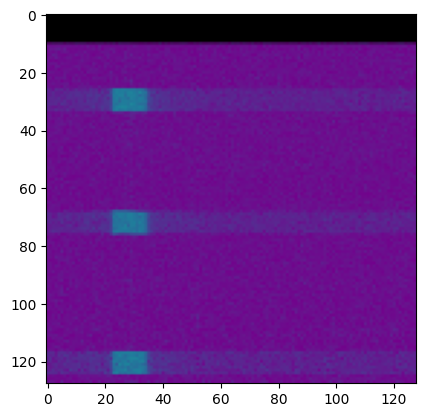

In [7]:
file = './datasets/lora/40fd4bd65f1e7dc0a7240387ca96cefb.png'
IMGSIZE=(128,128)
img = cv2.resize(cv2.imread(file), IMGSIZE)
plt.imshow(img)

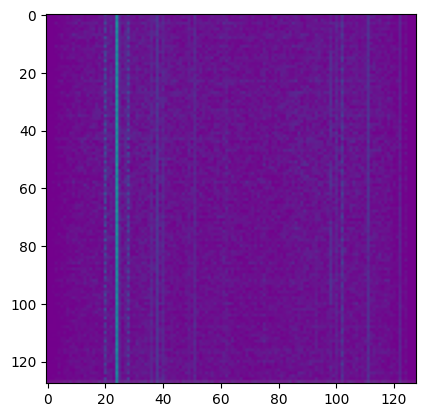

In [8]:
file = './datasets/vor/fd6e4c3603fccd0ae9e611350e7e284a.png'
IMGSIZE=(128,128)
img = cv2.resize(cv2.imread(file), IMGSIZE)
plt.imshow(img)

In [10]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    DATASET_ROOT_DIR,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=.2,
    subset="both",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=True,
)


Found 3624 files belonging to 20 classes.
Using 2900 files for training.
Using 724 files for validation.


2025-05-06 01:22:14.742310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-06 01:22:14.747609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-06 01:22:14.750672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
class ConvolutionBlock(layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, name=None):
        super().__init__(name=name)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides

        # First convolution
        self.conv1 = layers.Conv2D(
            filters,
            kernel_size,
            strides=strides,
            padding='same', # Use 'same' padding to maintain spatial dimensions
            use_bias=False 
        )
        # Batch Normalization after convolution
        self.bn = layers.BatchNormalization()
        # Activation (usually ReLU)
        self.relu = layers.Activation('relu')

    def call(self, inputs):
        # Apply the layers sequentially
        x = self.conv1(inputs)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Define the Identity Block (Residual Block)
# This block is used when the input and output shapes of the block
# are the same, allowing the shortcut connection to be a simple identity mapping.
class IdentityBlock(layers.Layer):
    def __init__(self, filters, kernel_size, name=None):
        super().__init__(name=name)
        self.filters = filters
        self.kernel_size = kernel_size

        self.conv1 = layers.Conv2D(filters, kernel_size, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.Activation('relu')

        self.conv2 = layers.Conv2D(filters, kernel_size, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()

    def call(self, inputs):
        # Store the input for the shortcut connection
        shortcut = inputs

        # Main Path
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = layers.Add()([x, shortcut])

        # Apply final activation after the addition
        x = layers.Activation('relu')(x)

        return x

In [12]:
 class SimpleResNet(keras.Model):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        # Initial Convolution and Pooling
        self.conv1 = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.Activation('relu')
        self.max_pool = layers.MaxPooling2D(3, strides=2, padding='same')

        self.id_block1 = IdentityBlock(filters=64, kernel_size=3)
        self.id_block2 = IdentityBlock(filters=64, kernel_size=3)

        # Example: A convolution block to change dimensions, followed by identity blocks
        # self.conv_block1 = ConvolutionBlock(filters=128, kernel_size=3, strides=2) # Stride 2 reduces spatial size
        # self.id_block3 = IdentityBlock(filters=128, kernel_size=3)

        # Global Average Pooling
        self.global_avg_pool = layers.GlobalAveragePooling2D()

        # Dense layer for classification
        self.classifier = layers.Dense(num_classes, activation='softmax') # Use softmax for multi-class output

    def call(self, inputs):
        # inputs should be (batch_size, 256, 256, 3)

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.max_pool(x)

        # Apply residual blocks
        x = self.id_block1(x)
        x = self.id_block2(x)

        # If using convolution block:
        # x = self.conv_block1(x)
        # x = self.id_block3(x)

        # Final layers
        x = self.global_avg_pool(x)
        outputs = self.classifier(x)

        return outputs

In [13]:
class ConvolutionBlock(layers.Layer):
    # Keep ConvolutionBlock as is, its layers are simple and built on first call
    def __init__(self, filters, kernel_size, strides=1, name=None):
        super().__init__(name=name)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides

        # First convolution
        self.conv1 = layers.Conv2D(
            filters,
            kernel_size,
            strides=strides,
            padding='same',
            use_bias=False
        )
        # Batch Normalization after convolution
        self.bn = layers.BatchNormalization()
        # Activation (usually ReLU)
        self.relu = layers.Activation('relu')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn(x)
        x = self.relu(x)
        return x

class IdentityBlock(layers.Layer):
    # Keep IdentityBlock as is, its layers are simple and built on first call
    def __init__(self, filters, kernel_size, name=None):
        super().__init__(name=name)
        self.filters = filters
        self.kernel_size = kernel_size

        self.conv1 = layers.Conv2D(filters, kernel_size, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.Activation('relu')

        self.conv2 = layers.Conv2D(filters, kernel_size, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()

    def call(self, inputs):
        shortcut = inputs

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = layers.Add()([x, shortcut])

        x = layers.Activation('relu')(x)

        return x


class SimpleResNet(keras.Model):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        # Layers are now created in the build method

    def build(self, input_shape):
        # input_shape will be something like (None, 256, 256, 3)

        # Initial Convolution and Pooling
        self.conv1 = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False, name='conv1')
        self.bn1 = layers.BatchNormalization(name='bn1')
        self.relu1 = layers.Activation('relu', name='relu1')
        self.max_pool = layers.MaxPooling2D(3, strides=2, padding='same', name='max_pool')

        # Residual Blocks
        # Pass the filters explicitly here
        self.id_block1 = IdentityBlock(filters=64, kernel_size=3, name='id_block1')
        self.id_block2 = IdentityBlock(filters=64, kernel_size=3, name='id_block2')

        # Example: A convolution block to change dimensions, followed by identity blocks
        # If you decide to use this, instantiate it here as well
        self.conv_block1 = ConvolutionBlock(filters=128, kernel_size=3, strides=2, name='conv_block1')
        self.id_block3 = IdentityBlock(filters=128, kernel_size=3, name='id_block3')


        # Global Average Pooling
        self.global_avg_pool = layers.GlobalAveragePooling2D(name='global_avg_pool')

        # Dense layer for classification
        self.classifier = layers.Dense(self.num_classes, activation='softmax', name='classifier') # Use softmax for multi-class output

        # It's good practice to call the parent build method
        super().build(input_shape)


    def call(self, inputs):
        # inputs should be (batch_size, 256, 256, 3)

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.max_pool(x)

        # Apply residual blocks
        x = self.id_block1(x)
        x = self.id_block2(x)

        # If using convolution block:
        # x = self.conv_block1(x)
        # x = self.id_block3(x)

        # Final layers
        x = self.global_avg_pool(x)
        outputs = self.classifier(x)

        return outputs

In [15]:
adm = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)

num_epochs = 200

batch = 32

callbacks_list = []


In [16]:
print("ELEMENT SPEC:", train_ds.element_spec)
for images, labels in train_ds.take(1):
    print("  batch x:", images.shape, type(images), 
          "\n  batch y:", labels, labels.shape if labels is not None else None)
    break

ELEMENT SPEC: (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
  batch x: (32, 256, 256, 3) <class 'tensorflow.python.framework.ops.EagerTensor'> 
  batch y: tf.Tensor(
[ 1 19 17 11  7 10 14 10 14 11 11 18 11  4 10 11 10  7  7  1 13 10 17 10
 19  0  4 11  9  0  7 14], shape=(32,), dtype=int32) (32,)


In [18]:
num_classes=20
inputs = keras.Input((256,256,3))
outputs = SimpleResNet(num_classes)(inputs)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 simple_res_net (SimpleResN  (None, 20)                159444    
 et)                                                             
                                                                 
Total params: 159444 (622.83 KB)
Trainable params: 158804 (620.33 KB)
Non-trainable params: 640 (2.50 KB)
_________________________________________________________________


In [19]:
num_classes = 20 # From the dataset

model = SimpleResNet(num_classes)

model.build((None, 256, 256, 3)) 

model.summary()

# model.compile(optimizer=adm, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = SimpleResNet(num_classes=20)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
history = model.fit(train_ds,
                    epochs=num_epochs,
                    callbacks=callbacks_list,
                    validation_data=val_ds)

Model: "simple_res_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              multiple                  9408      
                                                                 
 bn1 (BatchNormalization)    multiple                  256       
                                                                 
 relu1 (Activation)          multiple                  0         
                                                                 
 max_pool (MaxPooling2D)     multiple                  0         
                                                                 
 id_block1 (IdentityBlock)   multiple                  74240     
                                                                 
 id_block2 (IdentityBlock)   multiple                  74240     
                                                                 
 conv_block1 (ConvolutionBl  multiple             

2025-05-06 01:25:02.319068: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 2900
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-05-06 01:25:03.722404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2025-05-06 01:25:04.763057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-05-06 01:25:04.818309: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x74ac9871cc20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-06 01:25:04.818335: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-05-06 01:25:04.861968: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-06 01:25:05.186995: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the li

 1/91 [..............................] - ETA: 7:17 - loss: 4.3444 - accuracy: 0.0000e+00

2025-05-06 01:25:07.615260: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 552.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-06 01:25:07.743501: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 552.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


90/91 [============================>.] - ETA: 0s - loss: 2.5328 - accuracy: 0.2590

2025-05-06 01:25:14.687038: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 540.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


91/91 [==============================] - ETA: 0s - loss: 2.5300 - accuracy: 0.2593INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-05-06 01:25:14.922401: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 540.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-06 01:25:15.087866: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 724
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:4"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
att

91/91 [==============================] - 15s 115ms/step - loss: 2.5300 - accuracy: 0.2593 - val_loss: 4.0771 - val_accuracy: 0.1215
Epoch 2/200


2025-05-06 01:25:17.457994: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


91/91 [==============================] - 8s 79ms/step - loss: 2.2460 - accuracy: 0.2941 - val_loss: 3.3335 - val_accuracy: 0.1809
Epoch 3/200
91/91 [==============================] - 7s 77ms/step - loss: 2.1586 - accuracy: 0.3124 - val_loss: 2.7120 - val_accuracy: 0.2403
Epoch 4/200
91/91 [==============================] - 7s 78ms/step - loss: 2.1158 - accuracy: 0.3183 - val_loss: 2.2598 - val_accuracy: 0.2555
Epoch 5/200
91/91 [==============================] - 7s 76ms/step - loss: 2.0950 - accuracy: 0.3324 - val_loss: 2.1492 - val_accuracy: 0.3094
Epoch 6/200
91/91 [==============================] - 7s 77ms/step - loss: 2.0628 - accuracy: 0.3372 - val_loss: 2.1371 - val_accuracy: 0.3329
Epoch 7/200
91/91 [==============================] - 7s 75ms/step - loss: 2.0156 - accuracy: 0.3521 - val_loss: 2.0316 - val_accuracy: 0.3301
Epoch 8/200
91/91 [==============================] - 7s 74ms/step - loss: 2.0034 - accuracy: 0.3366 - val_loss: 1.9910 - val_accuracy: 0.3688
Epoch 9/200
91/91 